In [68]:
# Install silently (less verbose output)
!pip install -q pandas>=1.3.0 numpy>=1.21.0 matplotlib>=3.4.0 seaborn>=0.11.0 scikit-learn>=1.0.0 tensorflow>=2.8.0 nltk>=3.6.0 gensim>=4.0.0 spacy>=3.0.0 textblob>=0.15.0 vaderSentiment>=3.3.2

##### ============================================
#### PART 1: DATA COLLECTION
##### ============================================

In [69]:
import pandas as pd
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

tweets = pd.read_csv(r"/kaggle/input/tweets/stock_tweets.csv")
returns = pd.read_csv(r"/kaggle/input/tweets/stock_yfinance_data.csv")

tweets['Date'] = pd.to_datetime(tweets['Date'])
returns['Date'] = pd.to_datetime(returns['Date'])

print(f"Tweets: {tweets.shape} | Stocks: {returns.shape}")
print(f"Unique stocks: {tweets['Stock Name'].nunique()}")


LOADING DATA
Tweets: (80793, 4) | Stocks: (6300, 8)
Unique stocks: 25


##### ============================================
#### PART 2: EXPLORATORY DATA ANALYSIS
##### ============================================

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


EXPLORATORY DATA ANALYSIS


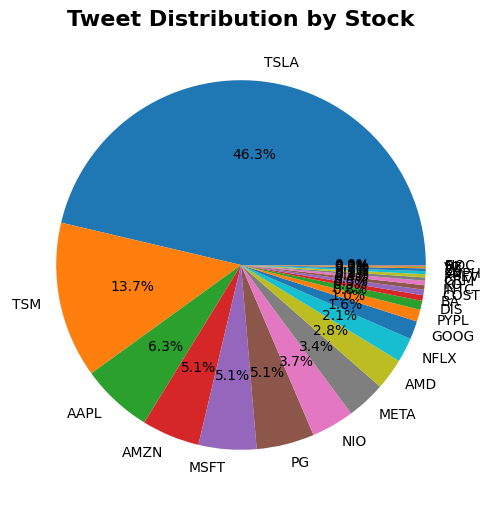

In [71]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Tweet distribution
count = tweets['Stock Name'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(count, labels=count.index, autopct='%1.1f%%')
plt.title('Tweet Distribution by Stock', fontsize=16, fontweight='bold')
plt.savefig('tweet_distribution.png', dpi=300)
plt.show()

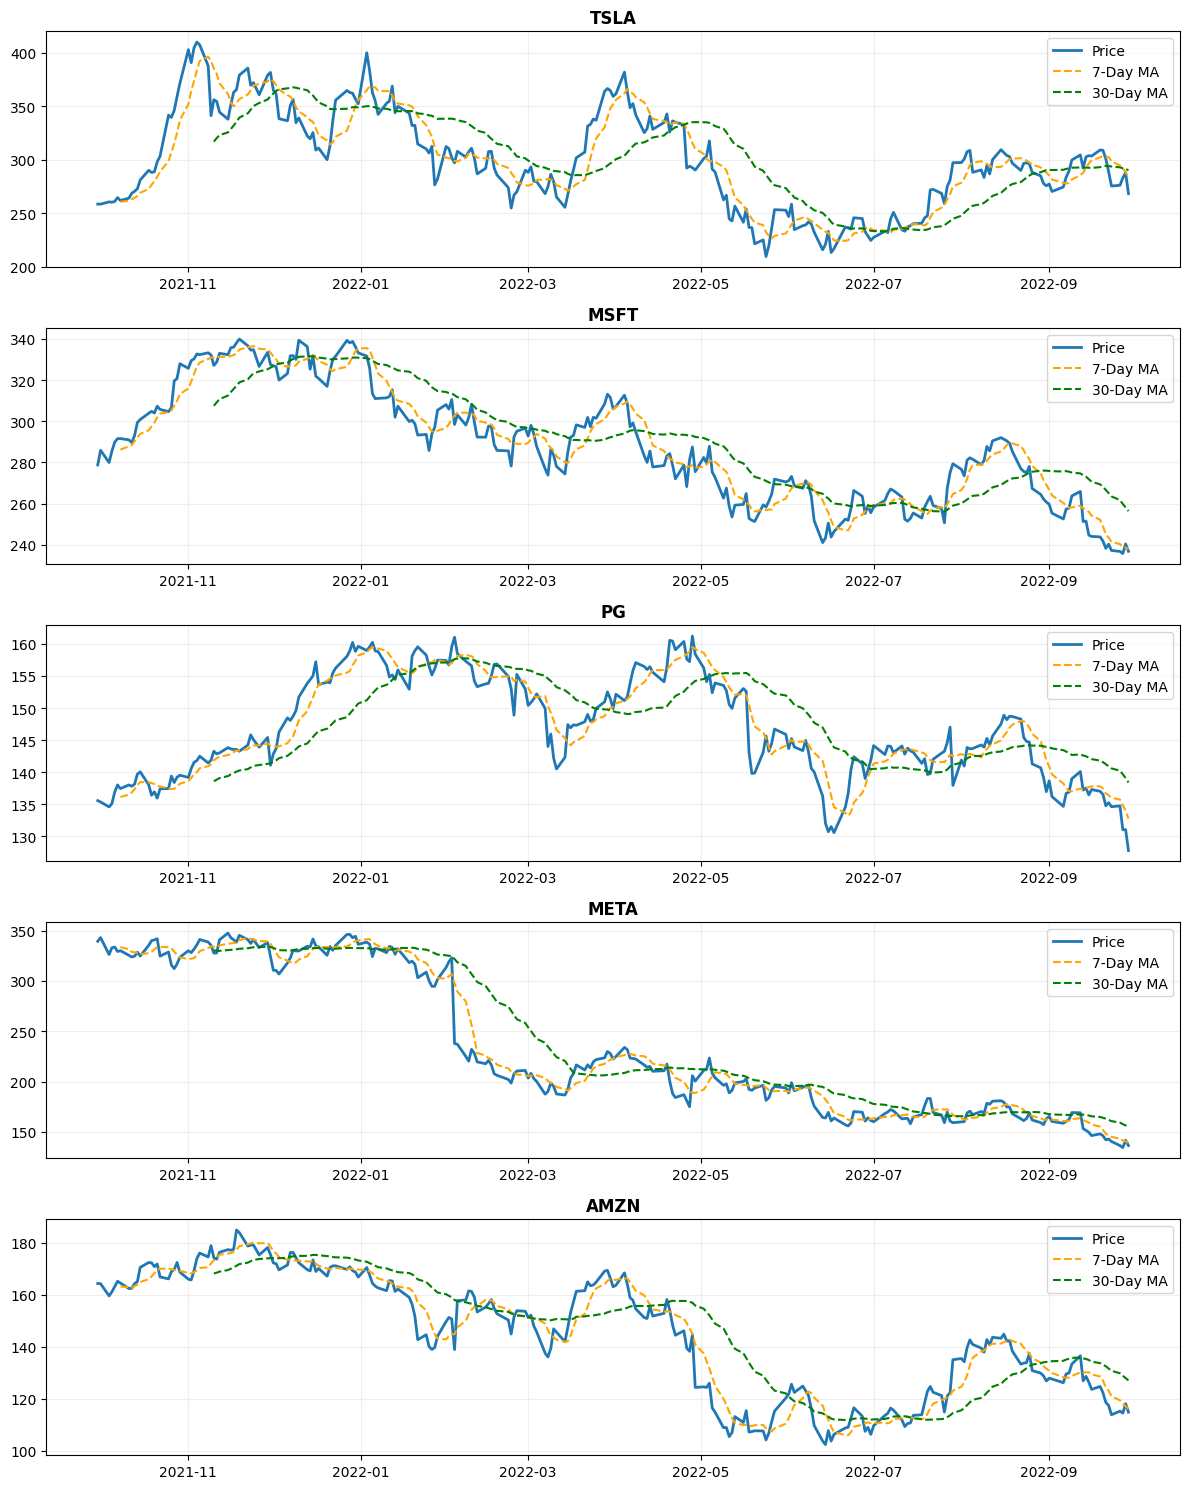

In [72]:
# Stock price trends
def plot_stock_trends(returns_df, n=5):
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n))
    stocks = returns_df['Stock Name'].unique()[:n]
    
    for i, stock in enumerate(stocks):
        data = returns_df[returns_df['Stock Name'] == stock].sort_values('Date')
        data['MA_7'] = data['Adj Close'].rolling(7).mean()
        data['MA_30'] = data['Adj Close'].rolling(30).mean()
        
        axs[i].plot(data['Date'], data['Adj Close'], label='Price', linewidth=2)
        axs[i].plot(data['Date'], data['MA_7'], label='7-Day MA', linestyle='--',color='orange')
        axs[i].plot(data['Date'], data['MA_30'], label='30-Day MA', linestyle='--',color='green')
        axs[i].set_title(f'{stock}', fontweight='bold')
        axs[i].legend()
        axs[i].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()

plot_stock_trends(returns)

##### ============================================
#### PART 3: TEXT PREPROCESSING
##### ============================================

In [73]:
import spacy
import re
print("\n" + "="*80)
print("TEXT PREPROCESSING")
print("="*80)

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    return " ".join(tokens)

tweets['cleaned_tweet'] = tweets['Tweet'].apply(preprocess_text)
print("Preprocessing complete!")


TEXT PREPROCESSING
Preprocessing complete!


In [74]:
pd.set_option('display.width', 1000)
tweets[['Tweet','cleaned_tweet']].head(20)

,Tweet,cleaned_tweet
0,Mainstream media has done an amazing job at br...,mainstream media amazing job brainwashing peop...
1,Tesla delivery estimates are at around 364k fr...,tesla delivery estimates analysts tsla
2,3/ Even if I include 63.0M unvested RSUs as of...,include unvested rsus additional equity needed...
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,hahaha trying stop tesla fsd bro shit bett...
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",stop trying kill kids sad deranged old man
5,@RealDanODowd @Tesla This is you https://t.co/...,
6,For years @WholeMarsBlog viciously silenced @T...,years viciously silenced critics failing silen...
7,$NIO just because I'm down money doesn't mean ...,nio money mean bad investment market sucks rig...
8,50 likes for some $SPY $TSLA charts to study!\...,likes spy tsla charts study
9,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,powerwalls waterproof bad wiring house d...


##### ============================================
#### PART 4: SENTIMENT ANALYSIS
##### ============================================

In [75]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

print("\n" + "="*80)
print("SENTIMENT ANALYSIS")
print("="*80)

# TextBlob
def get_textblob_sentiment(text):
    if not text:
        return 0
    return TextBlob(text).sentiment.polarity

# VADER (Better for social media)
vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if not text:
        return 0
    return vader.polarity_scores(text)['compound']

tweets['textblob_sentiment'] = tweets['cleaned_tweet'].apply(get_textblob_sentiment)
tweets['vader_sentiment'] = tweets['Tweet'].apply(get_vader_sentiment)



SENTIMENT ANALYSIS


In [76]:
tweets[['Tweet','cleaned_tweet','textblob_sentiment','vader_sentiment']].head(20)

,Tweet,cleaned_tweet,textblob_sentiment,vader_sentiment
0,Mainstream media has done an amazing job at br...,mainstream media amazing job brainwashing peop...,0.600000,0.0772
1,Tesla delivery estimates are at around 364k fr...,tesla delivery estimates analysts tsla,0.000000,0.0000
2,3/ Even if I include 63.0M unvested RSUs as of...,include unvested rsus additional equity needed...,0.018182,0.2960
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,hahaha trying stop tesla fsd bro shit bett...,0.066667,-0.7568
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",stop trying kill kids sad deranged old man,-0.200000,-0.8750
5,@RealDanODowd @Tesla This is you https://t.co/...,,0.000000,0.0000
6,For years @WholeMarsBlog viciously silenced @T...,years viciously silenced critics failing silen...,-0.600000,-0.9359
7,$NIO just because I'm down money doesn't mean ...,nio money mean bad investment market sucks rig...,0.060459,0.2500
8,50 likes for some $SPY $TSLA charts to study!\...,likes spy tsla charts study,0.000000,0.4753
9,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,powerwalls waterproof bad wiring house d...,-0.700000,-0.8625


In [77]:
# Classify sentiment
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    return 'Neutral'

tweets['sentiment_label'] = tweets['vader_sentiment'].apply(classify_sentiment)

# Distribution
sentiment_dist = tweets['sentiment_label'].value_counts()
print(f"\nSentiment Distribution:\n{sentiment_dist}")


Sentiment Distribution:
sentiment_label
Positive    41546
Neutral     22658
Negative    16589
Name: count, dtype: int64


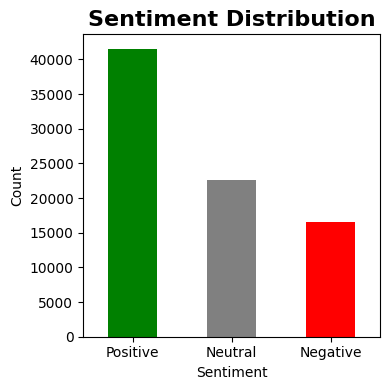

In [78]:
plt.figure(figsize=(4, 4))
sentiment_dist.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=300)
plt.show()

In [79]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize

print("\n" + "="*80)
print("TOPIC MODELING")
print("="*80)

sample = tweets.sample(n=min(1000, len(tweets)), random_state=42)
sample['tokens'] = sample['cleaned_tweet'].apply(lambda x: word_tokenize(x.lower()) if x else [])

dictionary = corpora.Dictionary(sample['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in sample['tokens']]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)

print("\nIdentified Topics:")
for idx, topic in lda_model.print_topics(num_words=7):
    print(f"Topic {idx}: {topic}")


TOPIC MODELING

Identified Topics:
Topic 0: 0.058*"amzn" + 0.025*"tsla" + 0.022*"msft" + 0.022*"aapl" + 0.021*"goog" + 0.017*"amd" + 0.015*"pypl"
Topic 1: 0.070*"aapl" + 0.048*"amzn" + 0.035*"tsla" + 0.029*"msft" + 0.028*"spy" + 0.023*"qqq" + 0.020*"googl"
Topic 2: 0.048*"tsla" + 0.038*"amp" + 0.037*"tsm" + 0.021*"stock" + 0.020*"new" + 0.019*"tesla" + 0.018*"like"
Topic 3: 0.061*"tsla" + 0.034*"tesla" + 0.030*"good" + 0.019*"day" + 0.015*"today" + 0.014*"short" + 0.014*"know"
Topic 4: 0.149*"tsla" + 0.045*"tesla" + 0.026*"shares" + 0.025*"elon" + 0.017*"today" + 0.016*"nio" + 0.014*"said"


##### ============================================
#### PART 4: FEATURE ENGINEERING
##### ============================================

In [80]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Aggregate daily sentiment
daily_sentiment = tweets.groupby(['Stock Name', tweets['Date'].dt.date]).agg({
    'vader_sentiment': ['mean', 'std', 'min', 'max'],
    'Tweet': 'count'
}).reset_index()

daily_sentiment.columns = ['Stock Name', 'Date', 'sentiment_mean', 'sentiment_std', 
                           'sentiment_min', 'sentiment_max', 'tweet_count']
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Merge with stock data
merged = returns.merge(daily_sentiment, on=['Stock Name', 'Date'], how='left')
merged['sentiment_mean'] = merged.groupby('Stock Name')['sentiment_mean'].fillna(method='ffill').fillna(0)
merged['tweet_count'] = merged['tweet_count'].fillna(0)
merged = merged.sort_values(['Stock Name', 'Date'])

# Create features
merged['Price_Change'] = merged.groupby('Stock Name')['Adj Close'].pct_change()
merged['Price_Change_7d'] = merged.groupby('Stock Name')['Adj Close'].pct_change(7)
merged['MA_7'] = merged.groupby('Stock Name')['Adj Close'].rolling(7).mean().reset_index(0, drop=True)
merged['MA_30'] = merged.groupby('Stock Name')['Adj Close'].rolling(30).mean().reset_index(0, drop=True)
merged['Volatility_7d'] = merged.groupby('Stock Name')['Adj Close'].rolling(7).std().reset_index(0, drop=True)
merged['Volatility_30d'] = merged.groupby('Stock Name')['Adj Close'].rolling(30).std().reset_index(0, drop=True)
merged['Volume_Change'] = merged.groupby('Stock Name')['Volume'].pct_change()
merged['Volume_MA_7'] = merged.groupby('Stock Name')['Volume'].rolling(7).mean().reset_index(0, drop=True)
merged['Sentiment_MA_3'] = merged.groupby('Stock Name')['sentiment_mean'].rolling(3).mean().reset_index(0, drop=True)
merged['Sentiment_MA_7'] = merged.groupby('Stock Name')['sentiment_mean'].rolling(7).mean().reset_index(0, drop=True)
merged['Sentiment_Change'] = merged.groupby('Stock Name')['sentiment_mean'].diff()

# Target: Next day's price
merged['Target'] = merged.groupby('Stock Name')['Adj Close'].shift(-1)
merged = merged.dropna()

print(f"Final dataset: {merged.shape}")


FEATURE ENGINEERING
Final dataset: (2811, 25)


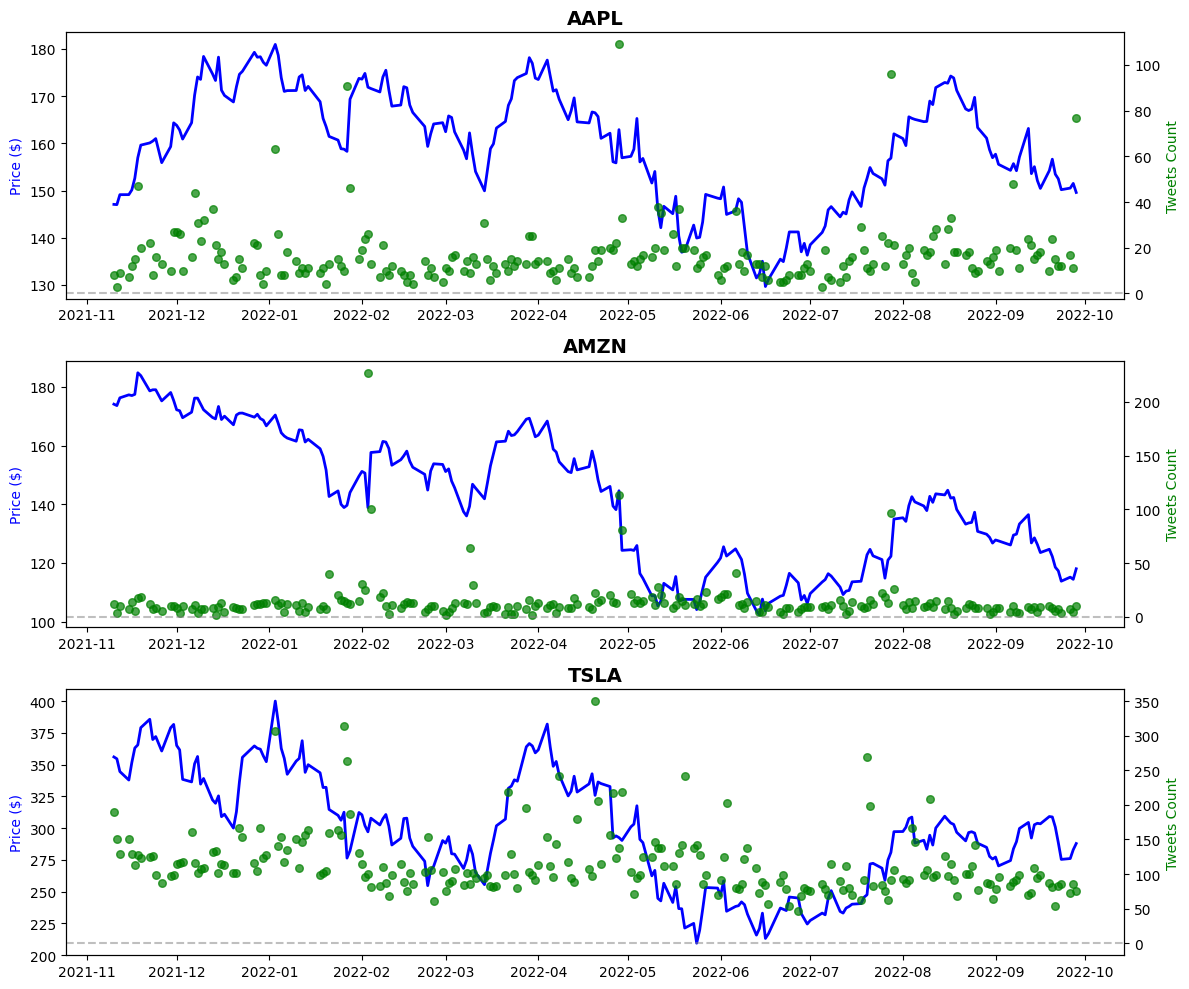

In [81]:
# tweets count vs stock
top_stocks = merged['Stock Name'].value_counts().head(3).index
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i, stock in enumerate(top_stocks):
    data = merged[merged['Stock Name'] == stock].sort_values('Date')
    
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    ax1.plot(data['Date'], data['Adj Close'], 'b-', linewidth=2, label='Price')
    ax2.scatter(
    data['Date'],
    data['tweet_count'],
    color='green',
    s=30,      
    alpha=0.7,
    label='Tweets Count'
)
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_ylabel('Price ($)', color='b')
    ax2.set_ylabel('Tweets Count', color='green')
    ax1.set_title(f'{stock}', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

In [82]:
merged.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Name', 'sentiment_mean', 'sentiment_std', 'sentiment_min', 'sentiment_max', 'tweet_count', 'Price_Change', 'Price_Change_7d', 'MA_7', 'MA_30', 'Volatility_7d', 'Volatility_30d', 'Volume_Change', 'Volume_MA_7', 'Sentiment_MA_3', 'Sentiment_MA_7', 'Sentiment_Change', 'Target'], dtype='object')

In [83]:
merged.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,sentiment_mean,sentiment_std,...,MA_7,MA_30,Volatility_7d,Volatility_30d,Volume_Change,Volume_MA_7,Sentiment_MA_3,Sentiment_MA_7,Sentiment_Change,Target
1793,2021-11-10,150.020004,150.130005,147.850006,147.919998,147.066452,65187100,AAPL,0.186062,0.316712,...,149.455538,145.644128,1.168131,3.980881,0.147905,6.092684e+07,0.271583,0.192404,-0.101853,147.016754
1794,2021-11-11,148.960007,149.429993,147.679993,147.869995,147.016754,41000000,AAPL,0.301900,0.362123,...,149.181220,145.862071,1.491040,3.865632,-0.371041,5.690941e+07,0.258626,0.206011,0.115838,149.124527
1795,2021-11-12,148.429993,150.399994,147.479996,149.990005,149.124527,63804000,AAPL,0.303189,0.349552,...,148.999529,146.112216,1.392525,3.824255,0.556195,5.823691e+07,0.263717,0.244138,0.001289,149.134460
1796,2021-11-15,150.369995,151.880005,149.429993,150.000000,149.134460,59222800,AAPL,0.196329,0.621321,...,148.894424,146.478848,1.342732,3.550602,-0.071801,5.806951e+07,0.267139,0.249013,-0.106860,150.128677
1797,2021-11-16,149.940002,151.490005,149.339996,151.000000,150.128677,59256200,AAPL,0.170025,0.542505,...,148.854653,146.813428,1.293689,3.397557,0.000564,5.718270e+07,0.223181,0.255170,-0.026304,152.604309



CORRELATION ANALYSIS


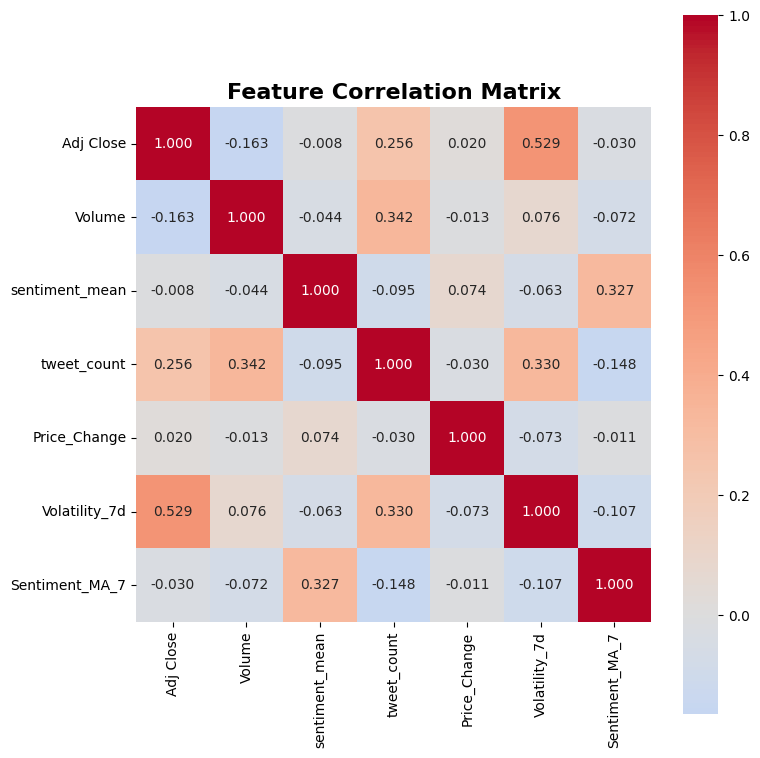

In [84]:
# correlation
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

corr_features = ['Adj Close', 'Volume', 'sentiment_mean', 'tweet_count', 
                 'Price_Change', 'Volatility_7d', 'Sentiment_MA_7']
corr_matrix = merged[corr_features].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

In [85]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [86]:
# print("\n" + "="*80)
# print("PREPARING DATA FOR MODELING")
# print("="*80)

# features = ['Adj Close', 'Volume', 'sentiment_mean', 'sentiment_std', 'tweet_count',
#             'MA_7', 'MA_30', 'Volatility_7d', 'Volatility_30d', 'Volume_MA_7',
#             'Sentiment_MA_3', 'Sentiment_MA_7', 'Sentiment_Change']

# X = merged[features].values
# y = merged['Target'].values

# # Train-test split (80-20, temporal order)
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# # Scale features
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print(f"Train: {X_train.shape} | Test: {X_test.shape}")

In [87]:
print("\n" + "="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)

features = ['Adj Close', 'Volume', 'sentiment_mean', 'sentiment_std', 'tweet_count',
            'MA_7', 'MA_30', 'Volatility_7d', 'Volatility_30d', 'Volume_MA_7',
            'Sentiment_MA_3', 'Sentiment_MA_7', 'Sentiment_Change']

# Remove rows where target is missing
merged_clean = merged.dropna(subset=['Target'])

X = merged_clean[features].values
y = merged_clean['Target'].values

print(f"Total samples: {len(X)}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Replace any NaN/Inf with 0
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

# Train-test split (80-20, temporal order)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train target range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Test target range: [{y_test.min():.2f}, {y_test.max():.2f}]")

# Scale features AND target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target variable too (IMPORTANT!)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"\nScaled train target range: [{y_train_scaled.min():.4f}, {y_train_scaled.max():.4f}]")
print(f"Scaled test target range: [{y_test_scaled.min():.4f}, {y_test_scaled.max():.4f}]")


PREPARING DATA FOR MODELING
Total samples: 2811
Features shape: (2811, 13)
Target shape: (2811,)

Train samples: 2248
Test samples: 563
Train target range: [12.71, 687.40]
Test target range: [19.08, 399.93]

Scaled train target range: [0.0000, 1.0000]
Scaled test target range: [0.0094, 0.5739]


In [88]:
print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST")
print("="*80)

rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, 
                          min_samples_leaf=2, random_state=42, n_jobs=-1)

# Train on SCALED target
rf.fit(X_train_scaled, y_train_scaled)

# Predict on scaled data
rf_pred_scaled = rf.predict(X_test_scaled)

# Transform predictions back to original scale
rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate on ORIGINAL scale
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)

print(f"MSE: {rf_mse:.4f} | R²: {rf_r2:.4f} | MAE: {rf_mae:.4f} | RMSE: {rf_rmse:.4f}")

# Sanity check
print(f"\nActual price range: [{y_test.min():.2f}, {y_test.max():.2f}]")
print(f"Predicted price range: [{rf_pred.min():.2f}, {rf_pred.max():.2f}]")


MODEL 1: RANDOM FOREST
MSE: 176.4849 | R²: 0.9845 | MAE: 7.8804 | RMSE: 13.2848

Actual price range: [19.08, 399.93]
Predicted price range: [18.52, 381.08]



Top 5 Features:
          Feature  Importance
0       Adj Close    0.985135
5            MA_7    0.009445
6           MA_30    0.003454
8  Volatility_30d    0.000357
4     tweet_count    0.000341


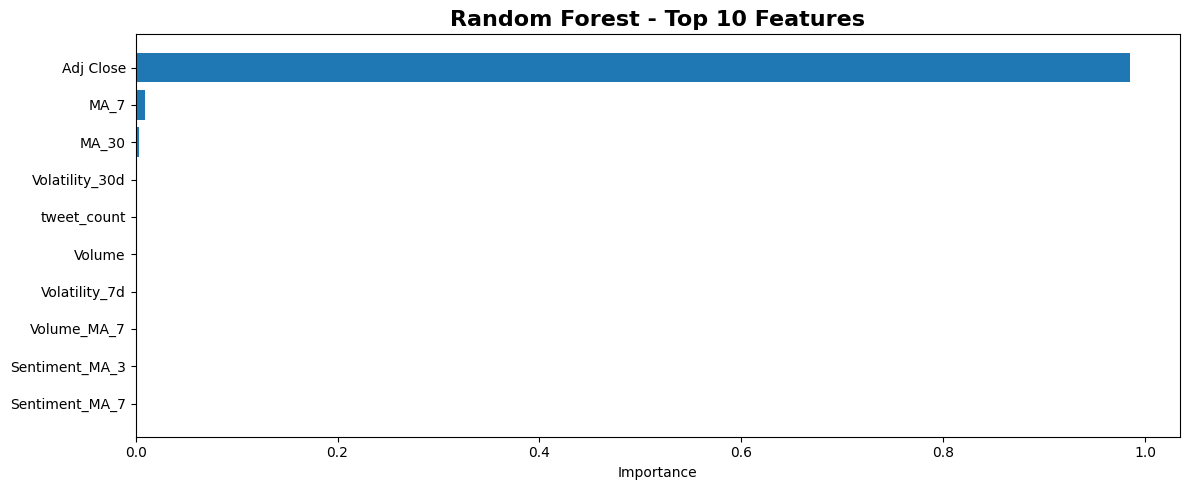

In [89]:
# Feature importance
importance = pd.DataFrame({
    'Feature': features, 
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 5 Features:\n{importance.head()}")

plt.figure(figsize=(12, 5))
plt.barh(importance['Feature'][:10], importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Random Forest - Top 10 Features', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_importance.png', dpi=300)
plt.show()

In [90]:
print("\n" + "="*80)
print("MODEL 2: GRADIENT BOOSTING")
print("="*80)

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train_scaled, y_train_scaled)

gb_pred_scaled = gb.predict(X_test_scaled)
gb_pred = scaler_y.inverse_transform(gb_pred_scaled.reshape(-1, 1)).flatten()

gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)

print(f"MSE: {gb_mse:.4f} | R²: {gb_r2:.4f} | MAE: {gb_mae:.4f} | RMSE: {gb_rmse:.4f}")



MODEL 2: GRADIENT BOOSTING
MSE: 717.9114 | R²: 0.9369 | MAE: 12.7254 | RMSE: 26.7939


#### ============================================================================
#### 12. MODEL 3: LSTM
#### ============================================================================

In [91]:
# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
# ============================================================================
# 12. MODEL 3: LSTM - COMPLETELY FIXED
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: LSTM NEURAL NETWORK")
print("="*80)

# Force CPU usage
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

def create_sequences(data, target, seq_length=10):
    """Create sequences ensuring proper alignment"""
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Create sequences from SCALED data
seq_len = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}")
print(f"Train target shape: {y_train_seq.shape}")
print(f"Test target shape: {y_test_seq.shape}")

# Diagnostic: Check data quality
print(f"\nData Quality Check:")
print(f"NaN in train sequences: {np.isnan(X_train_seq).sum()}")
print(f"NaN in test sequences: {np.isnan(X_test_seq).sum()}")
print(f"Train target range: [{y_train_seq.min():.4f}, {y_train_seq.max():.4f}]")
print(f"Test target range: [{y_test_seq.min():.4f}, {y_test_seq.max():.4f}]")

# Build LSTM model with simpler architecture
lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len, X_train_scaled.shape[1])),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])


from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

lstm.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\nLSTM Model Summary:")
lstm.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Train with verbose output to see progress
print("\nTraining LSTM model...")
history = lstm.fit(
    X_train_seq, y_train_seq, 
    epochs=100,  # increased epochs
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop], 
    verbose=1  # training progress
)


MODEL 3: LSTM NEURAL NETWORK
Training sequences: (2238, 10, 13)
Testing sequences: (553, 10, 13)
Train target shape: (2238,)
Test target shape: (553,)

Data Quality Check:
NaN in train sequences: 0
NaN in test sequences: 0
Train target range: [0.0000, 1.0000]
Test target range: [0.0094, 0.5739]

LSTM Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,301 (133.99 KB)

 Trainable params: 34,301 (133.99 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0180 - mae: 0.0927 - val_loss: 0.0032 - val_mae: 0.0376
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - mae: 0.0512 - val_loss: 0.0031 - val_mae: 0.0436
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - mae: 0.0504 - val_loss: 0.0025 - val_mae: 0.0345
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - mae: 0.0409 - val_loss: 0.0023 - val_mae: 0.0288
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - mae: 0.0427 - val_loss: 0.0018 - val_mae: 0.0197
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041 - mae: 0.0390 - val_loss: 0.0018 - val_mae: 0.0186
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0016 - val_mae: 0.0127
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - mae: 0.0352 - val_loss: 0.0017 - val_mae: 0.0184
Epoch 9/100
56/56 ━━━━━━━━━━━━━━

In [93]:
# Make predictions on SCALED data
print("\nMaking predictions...")
lstm_pred_scaled = lstm.predict(X_test_seq, verbose=0).flatten()

# CRITICAL: Inverse transform both predictions AND test targets
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
y_test_lstm_original = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# Calculate metrics on ORIGINAL scale
lstm_mse = mean_squared_error(y_test_lstm_original, lstm_pred)
lstm_r2 = r2_score(y_test_lstm_original, lstm_pred)
lstm_mae = mean_absolute_error(y_test_lstm_original, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)

print("\n" + "="*80)
print("LSTM RESULTS")
print("="*80)
print(f"MSE: {lstm_mse:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R² Score: {lstm_r2:.4f}")

# Diagnostic output
print(f"\nDiagnostic Info:")
print(f"Actual price range: [{y_test_lstm_original.min():.2f}, {y_test_lstm_original.max():.2f}]")
print(f"Predicted price range: [{lstm_pred.min():.2f}, {lstm_pred.max():.2f}]")
print(f"Mean actual price: {y_test_lstm_original.mean():.2f}")
print(f"Mean predicted price: {lstm_pred.mean():.2f}")

# Check if predictions are too constant
unique_predictions = len(np.unique(np.round(lstm_pred, 2)))
print(f"Unique predictions (rounded): {unique_predictions}/{len(lstm_pred)}")

# Baseline comparison
baseline_mse = mean_squared_error(y_test_lstm_original, [y_test_lstm_original.mean()]*len(y_test_lstm_original))
print(f"\nBaseline (mean) MSE: {baseline_mse:.4f}")
print(f"Model MSE: {lstm_mse:.4f}")
print(f"Model improvement: {((baseline_mse - lstm_mse) / baseline_mse * 100):.2f}%")



Making predictions...

LSTM RESULTS
MSE: 1322.5672
RMSE: 36.3671
MAE: 21.9605
R² Score: 0.8850

Diagnostic Info:
Actual price range: [19.08, 399.93]
Predicted price range: [29.09, 368.13]
Mean actual price: 181.03
Mean predicted price: 162.48
Unique predictions (rounded): 542/553

Baseline (mean) MSE: 11496.0078
Model MSE: 1322.5672
Model improvement: 88.50%


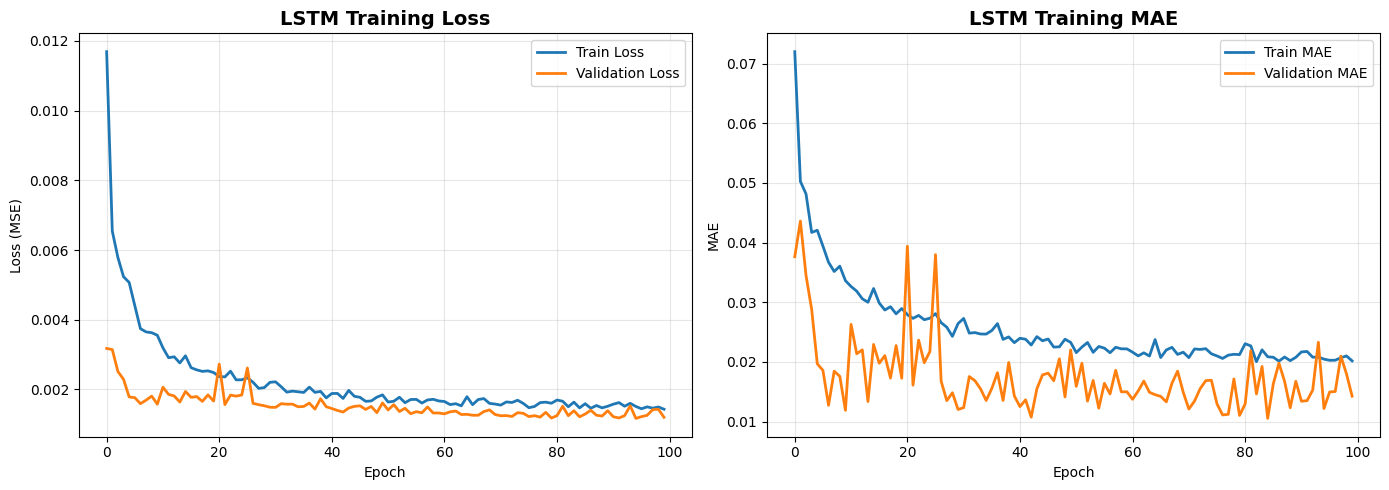

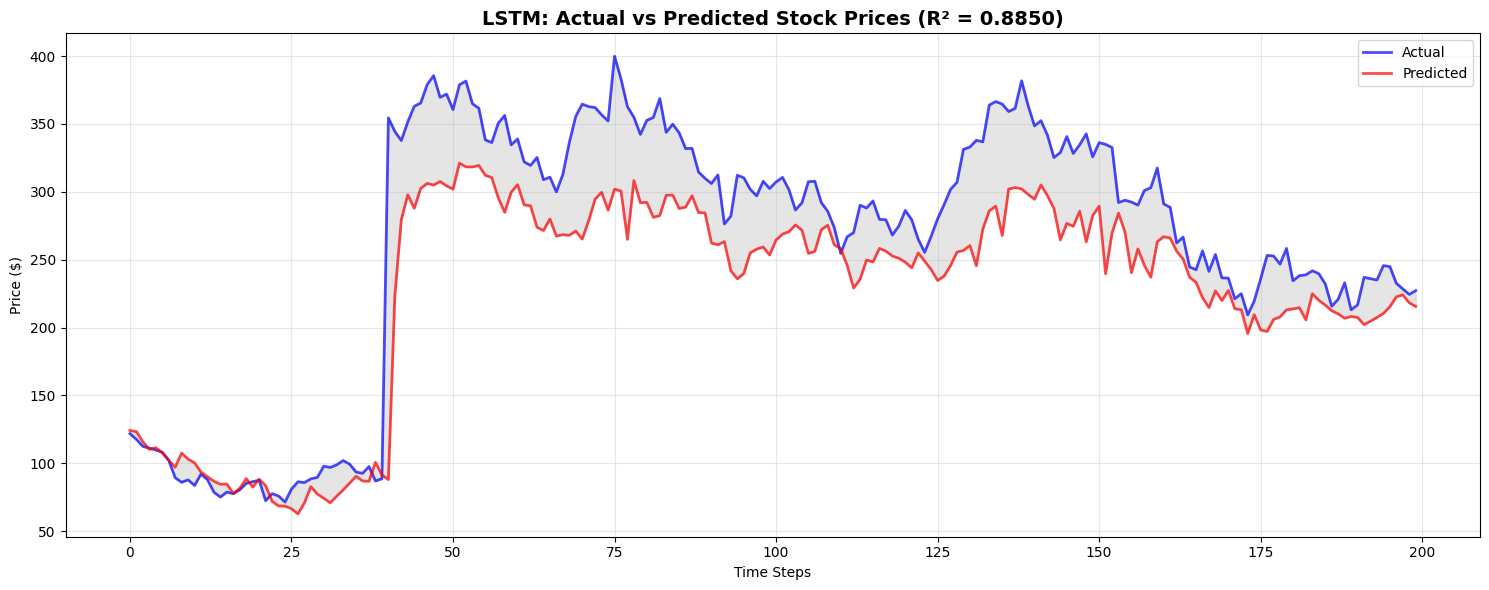

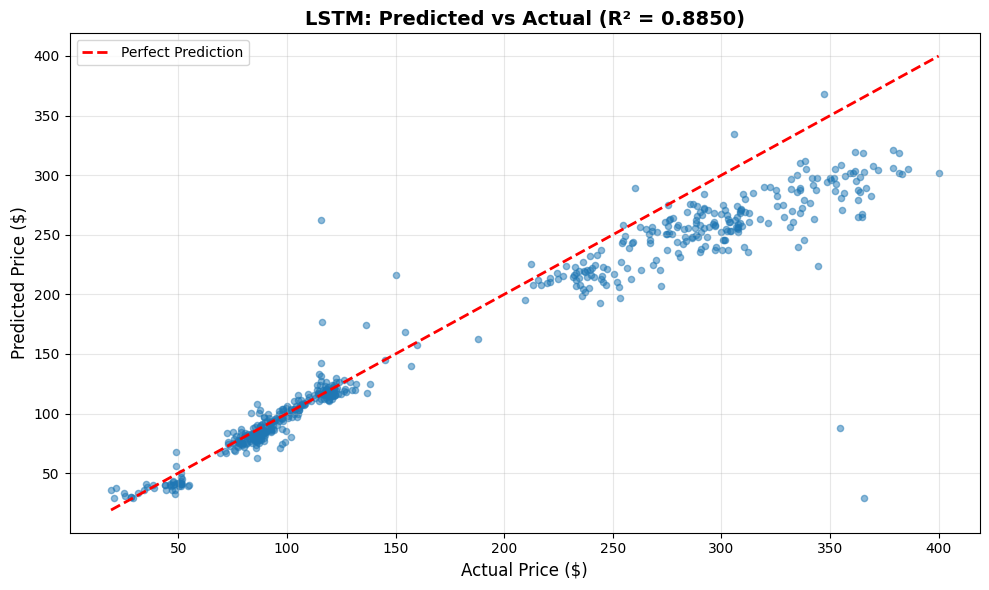

In [94]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Training Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('LSTM Training MAE', fontweight='bold', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('lstm_training_history.png', dpi=300)
plt.show()

# Plot predictions vs actuals
plt.figure(figsize=(15, 6))

# Plot first 200 points
n_points = min(200, len(lstm_pred))

plt.plot(y_test_lstm_original[:n_points], label='Actual', linewidth=2, alpha=0.7, color='blue')
plt.plot(lstm_pred[:n_points], label='Predicted', linewidth=2, alpha=0.7, color='red')
plt.fill_between(range(n_points), 
                 y_test_lstm_original[:n_points], 
                 lstm_pred[:n_points], 
                 alpha=0.2, color='gray')

plt.title(f'LSTM: Actual vs Predicted Stock Prices (R² = {lstm_r2:.4f})', 
          fontweight='bold', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('lstm_predictions.png', dpi=300)
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lstm_original, lstm_pred, alpha=0.5, s=20)
plt.plot([y_test_lstm_original.min(), y_test_lstm_original.max()], 
         [y_test_lstm_original.min(), y_test_lstm_original.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'LSTM: Predicted vs Actual (R² = {lstm_r2:.4f})', 
          fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('lstm_scatter.png', dpi=300)
plt.show()

#### ============================================================================
#### 13. MODEL COMPARISON
#### ============================================================================


MODEL COMPARISON
            Model         MSE      RMSE       MAE  R² Score
    Random Forest  176.484917 13.284763  7.880384  0.984490
Gradient Boosting  717.911430 26.793869 12.725421  0.936906
             LSTM 1322.567180 36.367117 21.960508  0.884954


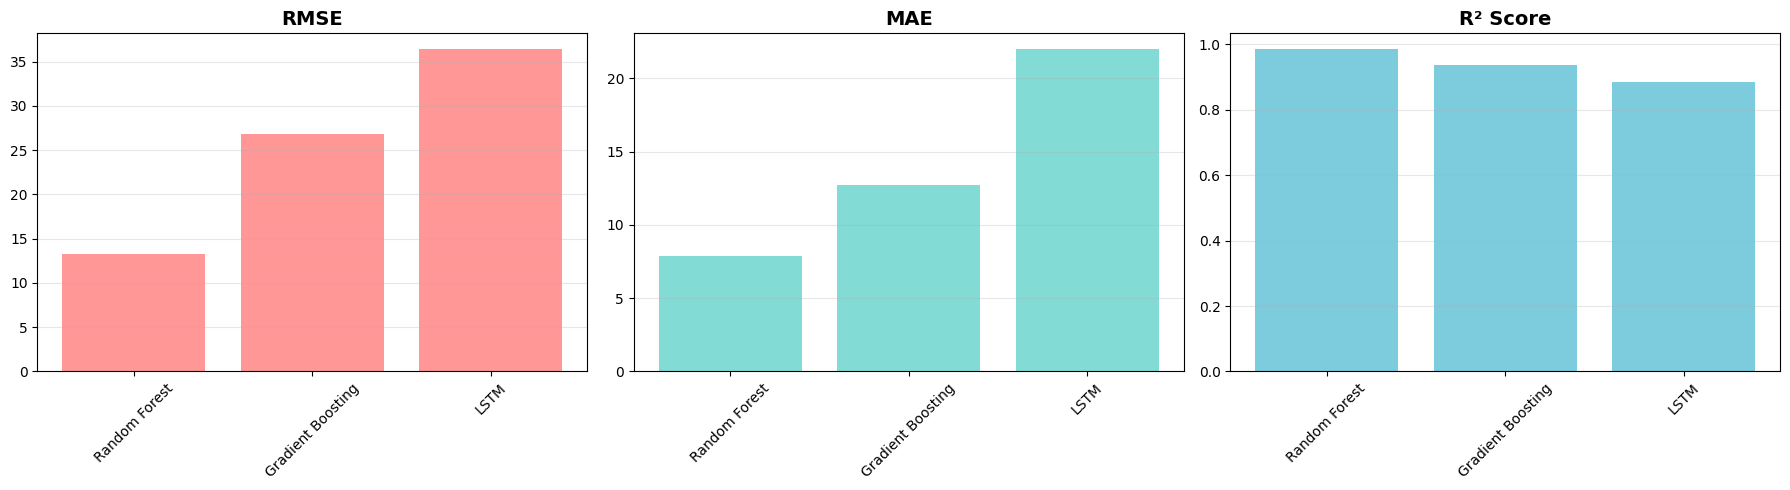

In [95]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'LSTM'],
    'MSE': [rf_mse, gb_mse, lstm_mse],
    'RMSE': [np.sqrt(rf_mse), np.sqrt(gb_mse), np.sqrt(lstm_mse)],
    'MAE': [rf_mae, gb_mae, lstm_mae],
    'R² Score': [rf_r2, gb_r2, lstm_r2]
})

print(comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['RMSE', 'MAE', 'R² Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, metric in enumerate(metrics):
    axes[i].bar(comparison['Model'], comparison[metric], color=colors[i], alpha=0.7)
    axes[i].set_title(f'{metric}', fontweight='bold', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# plt.savefig('model_comparison.png', dpi=300)
plt.show()

##### ============================================================================
##### 14. PREDICTION VISUALIZATION
##### ============================================================================



PREDICTIONS vs ACTUAL


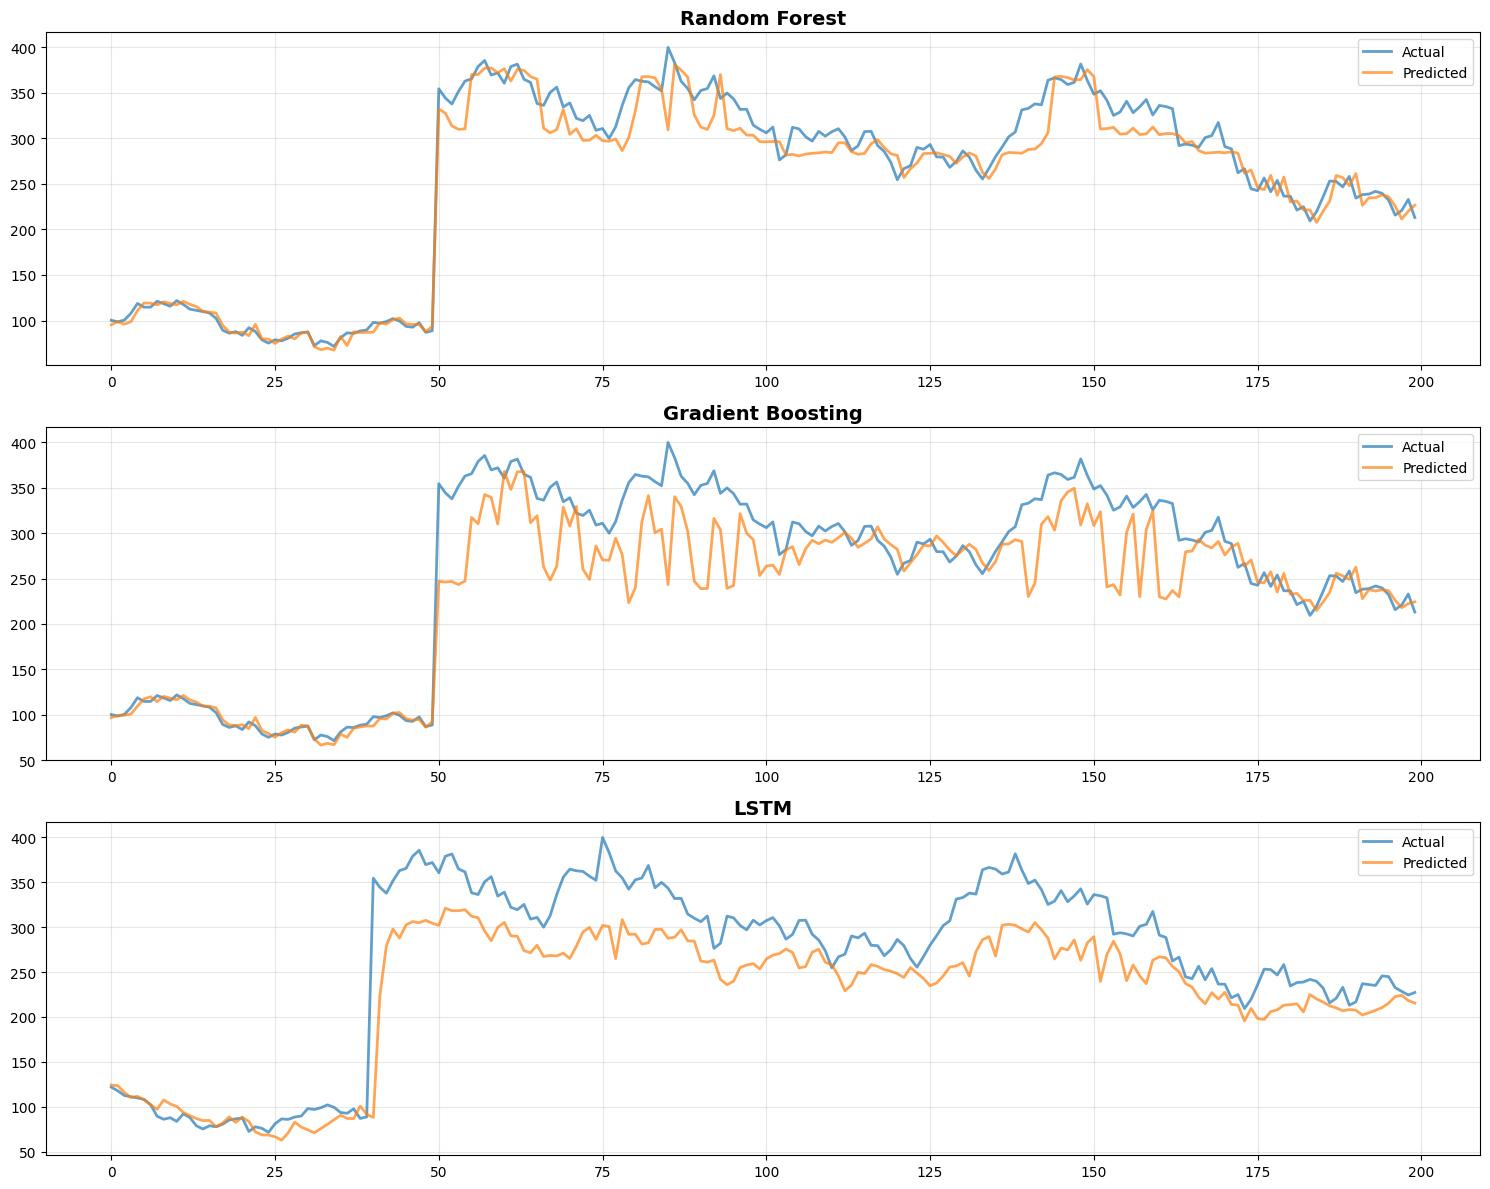

In [96]:

print("\n" + "="*80)
print("PREDICTIONS vs ACTUAL")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

axes[0].plot(y_test[:200], label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(rf_pred[:200], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title('Random Forest', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(y_test[:200], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(gb_pred[:200], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title('Gradient Boosting', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(y_test_lstm_original[:200], label='Actual', linewidth=2, alpha=0.7)
axes[2].plot(lstm_pred[:200], label='Predicted', linewidth=2, alpha=0.7)
axes[2].set_title('LSTM', fontweight='bold', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



SENTIMENT vs STOCK PRICE


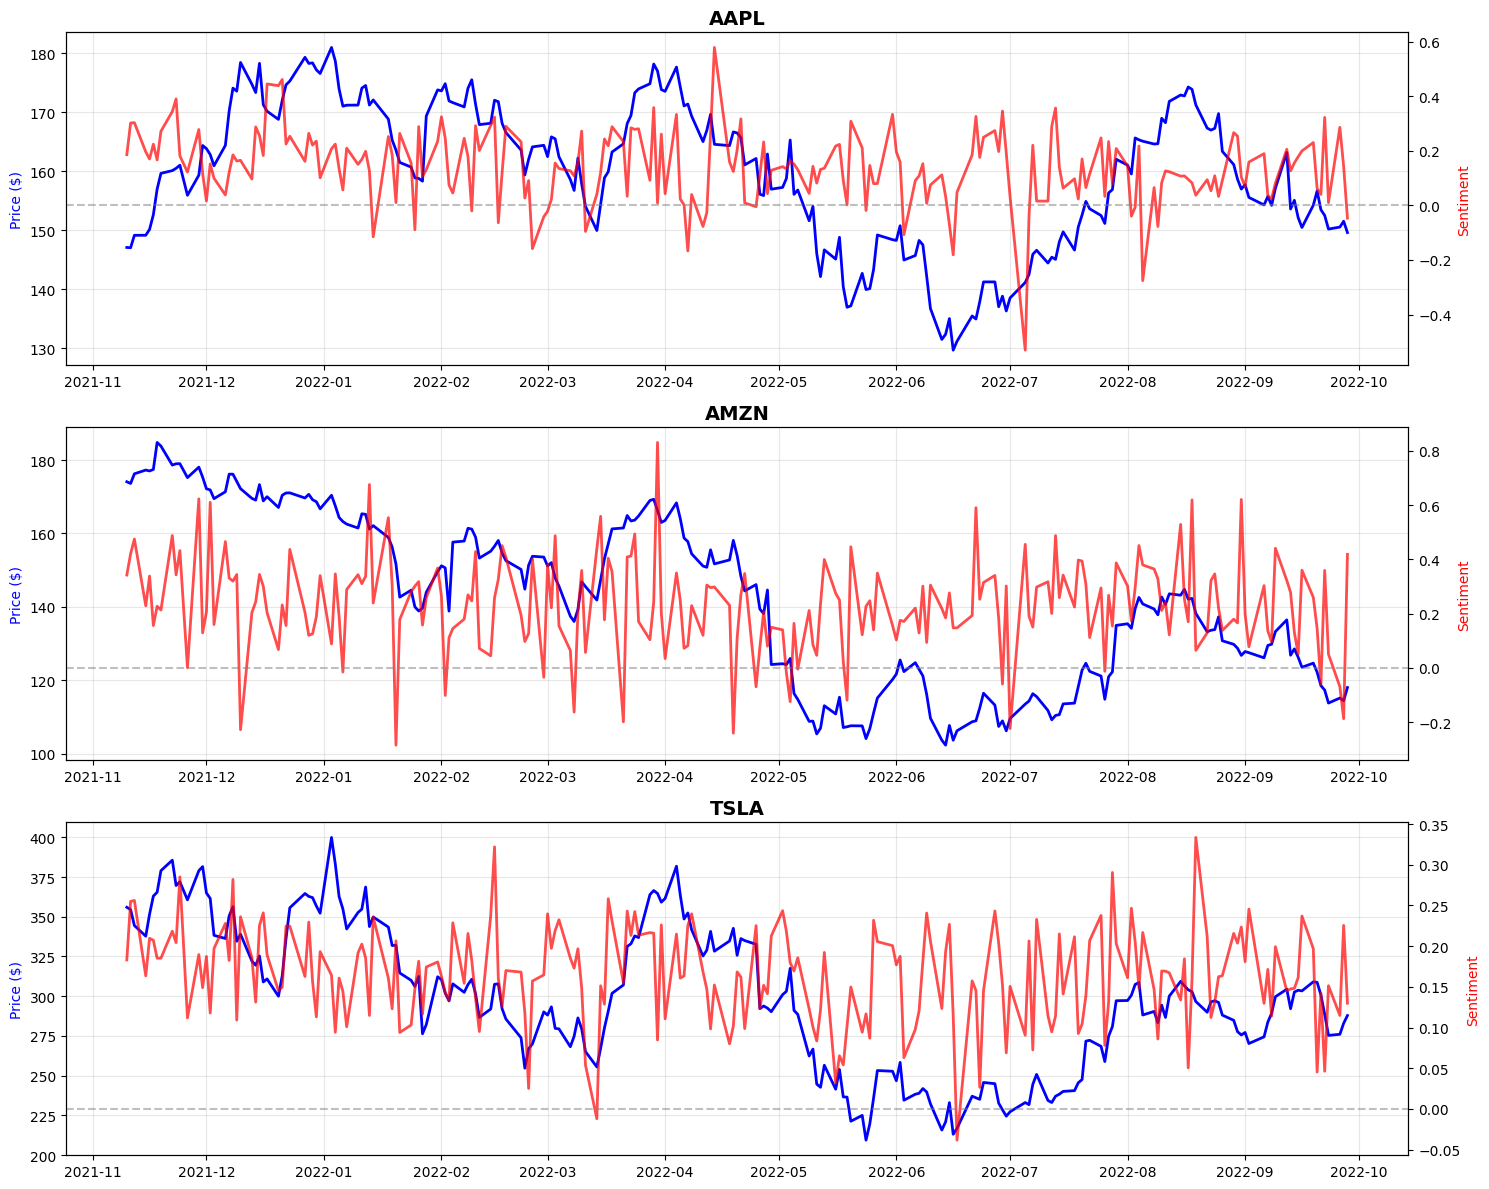

In [97]:
# ============================================================================
# 15. SENTIMENT vs PRICE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SENTIMENT vs STOCK PRICE")
print("="*80)

top_stocks = merged['Stock Name'].value_counts().head(3).index

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, stock in enumerate(top_stocks):
    data = merged[merged['Stock Name'] == stock].sort_values('Date')
    
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    ax1.plot(data['Date'], data['Adj Close'], 'b-', linewidth=2, label='Price')
    ax2.plot(data['Date'], data['sentiment_mean'], 'r-', linewidth=2, alpha=0.7, label='Sentiment')
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_ylabel('Price ($)', color='b')
    ax2.set_ylabel('Sentiment', color='r')
    ax1.set_title(f'{stock}', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('sentiment_vs_price.png', dpi=300)
plt.show()

In [98]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

best_model = comparison.loc[comparison['R² Score'].idxmax(), 'Model']
best_r2 = comparison['R² Score'].max()

print(f"\nDataset: {len(tweets):,} tweets | {tweets['Stock Name'].nunique()} stocks")
print(f"Best Model: {best_model} (R² = {best_r2:.4f})")
print(f"Features: {len(features)} engineered features")
print(f"Sentiment Methods: TextBlob + VADER")
print(f"Models Tested: Random Forest, Gradient Boosting, LSTM")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


FINAL SUMMARY

Dataset: 80,793 tweets | 25 stocks
Best Model: Random Forest (R² = 0.9845)
Features: 13 engineered features
Sentiment Methods: TextBlob + VADER
Models Tested: Random Forest, Gradient Boosting, LSTM

ANALYSIS COMPLETE!
